In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import importlib
import os
from glob import glob
from tqdm import tqdm
import numpy as np

import datetime

from  utility_programs.read_routines import SAMI

import cartopy.crs as ccrs

from datetime import datetime
from scipy.spatial import KDTree


import cartopy.crs as ccrs

In [2]:
sami_data_path = '/glade/u/home/abukowski/scratch/simstorm-20110521/GITM-simstorm-run1/sami-gitm-coupled/'

In [3]:
SAMI = importlib.reload(SAMI)

In [4]:
nz, nf, nlt, nt = SAMI.get_grid_elems_from_parammod(sami_data_path)

old_shape = [nlt, nf, nz]

grid2 = SAMI.get_sami_grid(sami_data_path, nlt, nf, nz)

data2, times = SAMI.read_to_nparray(sami_data_path, datetime(2011,5,20),
                                    datetime(2011,5,21,12), 1, 2, cols='edens')

grid = {};

skipping deni1u.dat because it is not in cols
skipping deni2u.dat because it is not in cols
skipping deni3u.dat because it is not in cols
skipping deni4u.dat because it is not in cols
skipping deni5u.dat because it is not in cols
skipping deni6u.dat because it is not in cols
skipping deni7u.dat because it is not in cols
skipping denn1u.dat because it is not in cols
skipping denn2u.dat because it is not in cols
skipping denn3u.dat because it is not in cols
skipping denn4u.dat because it is not in cols
skipping denn5u.dat because it is not in cols
skipping denn6u.dat because it is not in cols
skipping denn7u.dat because it is not in cols
skipping teu.dat because it is not in cols
skipping ti1u.dat because it is not in cols
skipping ti2u.dat because it is not in cols
skipping ti5u.dat because it is not in cols
skipping vsi1u.dat because it is not in cols
skipping vsi2u.dat because it is not in cols
skipping u1pu.dat because it is not in cols
skipping u3hu.dat because it is not in cols
ski

In [5]:
np.sum(data2['data']['edens']), data2['data']['edens'].shape

(8006212318202.014, (80, 72, 256, 36))

In [6]:
nlt, nf, nz

(80, 72, 256)

In [7]:
# inmask = np.where(grid2['alt'] < 4000, )

In [8]:
for k in grid2.keys():
    grid[k] = grid2[k].flatten()
    grid2[k] = grid2[k]
    print(k, grid[k].shape, grid2[k].shape)

glat (1474560,) (80, 72, 256)
glon (1474560,) (80, 72, 256)
alt (1474560,) (80, 72, 256)
mlat (1474560,) (80, 72, 256)
mlon (1474560,) (80, 72, 256)
malt (1474560,) (80, 72, 256)


In [9]:
"""
- convert to cartesian
- for pt in output grid:
    - find nearest input grid pt.
    - build cube with input grid
    - 3D interpolate (in cartesian)
    - i guess store weigts? somehow?
- save weights.


""";

In [10]:
def latlonalt_to_cart(lat, lon, radius):
    lat = np.deg2rad(lat)
    lon = np.deg2rad(lon)
    x = radius * np.cos(lat) * np.cos(lon)
    y = radius * np.cos(lat) * np.sin(lon)
    z = radius * np.sin(lat)
    return np.array([x,y,z])

In [11]:
in_cart = latlonalt_to_cart(grid['glat'], grid['glon'], grid['malt'])

In [12]:
latout = np.arange(-90,90,1)
lonout = np.arange(0,360,1)
altout = np.arange(100,2200,100)

out_lats = []
out_lons = []
out_alts = []



for a in latout:
    for o in lonout:
        for l in altout:
            out_lats.append(a)
            out_lons.append(o)
            out_alts.append(l)
            
            

out_cart = latlonalt_to_cart(out_lats, out_lons, np.array(out_alts)+6371)



In [13]:
in_cart.shape, out_cart.shape

((3, 1474560), (3, 1360800))

In [14]:
tree = KDTree(in_cart.T)
dists, nearest = tree.query(out_cart.T)

In [15]:
len(np.unique(nearest))

410671

In [16]:
out_lats[0], out_lons[0], out_alts[0]

(-90, 0, 100)

In [17]:
for k in grid2.keys():
    print(k, grid[k][nearest[0]])

glat -88.99971
glon 99.99974
alt 118.805176
mlat -75.12826
mlon 20.249998
malt 6490.0054


In [42]:

badbadbad = []


zero1ddst = np.empty(len(in_cart[0]))
zero3ddst = np.empty([len(in_cart[1]),3])
zero1dsrc = np.empty([len(out_cart[0]),8])
zero3dsrc = np.empty([len(out_cart[0]),8,3])


weights = {'weight':zero1dsrc.copy(),
           'dstidxs1d':zero1dsrc.copy(),
           'dstidxs3d':zero3dsrc.copy(), 
           'srcidxs1d':zero1dsrc.copy(),
          'srcidxs3d':zero3dsrc.copy(),
           'dists':zero1dsrc.copy()}
# print(weights)
# w2 = np.zeros([len(in_cart[0]),len(out_cart[0])])


for n, i in enumerate(nearest):
    
    l, f, z = np.unravel_index(i, old_shape)
    
    if l == old_shape[0]-1:
        l2 = 0
    else:
        l2 = l+1
    
    if z == 0:
        z2 = -1
    else:
        z2 = z-1
    
    
    f2 = f+1
    if f == old_shape[1]-1:
        badbadbad.append([l,f,z,i,n])
        continue
    
    cs = [[l,  f,  z  ],
          [l,  f,  z2 ],
          [l2, f,  z2 ],
          [l2, f,  z  ],
          [l,  f2, z  ],
          [l,  f2, z  ],
          [l2, f2, z2 ],
          [l2, f2, z2 ],]
    
    weights['srcidxs3d'][n] = cs
    
    
    id_pt = []
    xs = []
    ys = []
    zs = []
    for c in cs:
        try:
            index = np.ravel_multi_index(c,old_shape)
        except:
            break
        id_pt.append(index)
        
        xs.append(in_cart[0,index])
        ys.append(in_cart[1,index])
        zs.append(in_cart[2,index])
        
    d = np.sqrt((xs-out_cart[0,n])**2 + (ys-out_cart[1,n])**2 + (zs-out_cart[2,n])**2)
    dtot=np.sum(d)
    
    weights['weight'][n] = 1/(d)
    # weights['weights'].append(d/dtot)
    
    

        
    weights['srcidxs1d'][n]=id_pt


    weights['dstidxs1d'][n]=i
    
    
    

In [43]:
c, old_shape

([37, 71, 166], [80, 72, 256])

In [44]:
weights.keys()

dict_keys(['weight', 'dstidxs1d', 'dstidxs3d', 'srcidxs1d', 'srcidxs3d', 'dists'])

In [45]:
for k in weights.keys():
    print(k, np.array(weights[k]).shape, np.sum(weights[k]))

weight (1360800, 8) 54507.90146396903
dstidxs1d (1360800, 8) 7550098979000.0
dstidxs3d (1360800, 8, 3) 0.0
srcidxs1d (1360800, 8) 7533735473348.0
srcidxs3d (1360800, 8, 3) 2310092544.0
dists (1360800, 8) 0.0


In [46]:
np.array(badbadbad).shape

(12004, 5)

In [47]:
t0 = data2['data']['edens'][:,:,:]

In [48]:
t0.shape, np.sum(t0)

((80, 72, 256, 36), 8006212318202.014)

In [49]:
out = []
for t in range(t0.shape[-1]):
    out.append(np.sum(weights['weight'] * np.take(t0[:,:,:,t],weights['srcidxs1d'].astype(int)), axis=1) / np.sum(weights['weight'], axis=1))

/glade/scratch/abukowski/ipykernel_52053/2933139722.py:3: RuntimeWarning: invalid value encountered in divide
  out.append(np.sum(weights['weight'] * np.take(t0[:,:,:,t],weights['srcidxs1d'].astype(int)), axis=1) / np.sum(weights['weight'], axis=1))


In [50]:
out = np.array(out)

In [51]:
out.shape

(36, 1360800)

In [52]:
ds =  xr.Dataset(coords={
    'time':(['time'],times),
    'alt':(['alt'],altout),
    'lat':(['lat'],latout),
    'lon':(['lon'],lonout)},
                     data_vars={
                         'dene':(['time','lat','lon','alt'],out.reshape(len(times),len(latout), len(lonout), len(altout)))})

In [53]:
ds

<xarray.Dataset>
Dimensions:  (time: 36, lat: 180, lon: 360, alt: 21)
Coordinates:
  * time     (time) datetime64[ns] 2011-05-21T11:00:00 ... 2011-05-21T13:55:00
  * alt      (alt) int64 100 200 300 400 500 600 ... 1700 1800 1900 2000 2100
  * lat      (lat) int64 -90 -89 -88 -87 -86 -85 -84 ... 83 84 85 86 87 88 89
  * lon      (lon) int64 0 1 2 3 4 5 6 7 8 ... 352 353 354 355 356 357 358 359
Data variables:
    dene     (time, lat, lon, alt) float64 0.0 0.0 0.0 ... 4.529e+03 3.855e+03

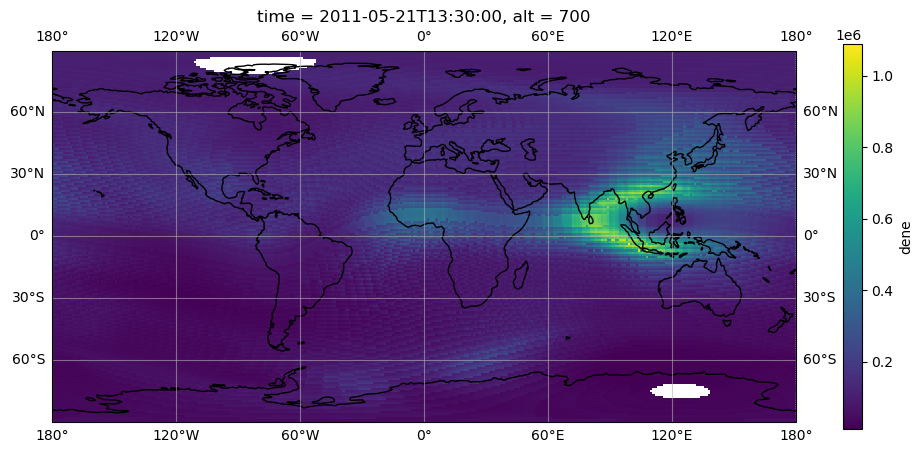

In [54]:
plt.figure(figsize = (12,5))
ax = plt.subplot(projection=ccrs.PlateCarree(), )
ds.dene.sel(alt=650, method='nearest').isel(time=30).plot(ax = ax, aa = True)
ax.coastlines()
ax.gridlines(draw_labels = True, alpha = 0.6)

In [31]:
plt.imshow(out.reshape(len(latout), len(lonout), len(altout))[:,:,5], interpolation = 'bicubic', interpolation_stage='rgba')

ValueError: cannot reshape array of size 48988800 into shape (180,360,21)